In [2]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [3]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator(g=[0.3, 1, 1.2], lr=[0.001, 0.01])
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))

In [ ]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
file_names = []
for params, i_seed in micro_configs:
    
    np.random.seed(i_seed)

    task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
    N_train = int(200 / params['lr'])
    N_test = 10000
    checkpoint_interval = int(1 / params['lr'])
    sigma = 0
    data = task.gen_data(N_train, N_test)

    n_in = task.n_in
    n_hidden = 32
    n_out = task.n_out

    W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
    W_rec = params['g'] * np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
    W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

    b_rec = np.zeros(n_hidden)
    b_out = np.zeros(n_out)

    alpha = 1
    sigma = 0
    
    rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
              activation=tanh,
              alpha=alpha,
              output=identity,
              loss=mean_squared_error)

    learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
    optimizer = SGD_Momentum(lr=params['lr'], mu=0.6)

    monitors = []

    sim = Simulation(rnn)
    sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
            sigma=sigma,
            monitors=monitors,
            verbose=False,
            report_accuracy=False,
            report_loss=True,
            checkpoint_optimizer=True,
            checkpoint_interval=checkpoint_interval)
    
    file_name = root_name + '_seed={}'.format(i_seed)
    for key in params.keys():
        file_name += '_{}={}'.format(key, str(params[key]).replace('.', ','))
        
    file_names.append(file_name)
    
    print('finish simulation: ')
    for key in params.keys():
        print('{}:, {}, seed = {}'.format(key, params[key], i_seed))
    if np.isnan(rnn.W_rec[0, 0]):
        print('MISTAKES WERE MADE')
        break
    
    
    ### --- SAVE RUN --- ###
    with open(os.path.join('saved_runs/', file_name), 'wb') as f:
        saved_run = {'sim': sim, 'task': task}
        pickle.dump(saved_run, f)

finish simulation: 
g:, 0.3, seed = 0
lr:, 0.001, seed = 0
finish simulation: 
g:, 0.3, seed = 1
lr:, 0.001, seed = 1
finish simulation: 
g:, 0.3, seed = 2
lr:, 0.001, seed = 2
finish simulation: 
g:, 0.3, seed = 0
lr:, 0.01, seed = 0
finish simulation: 
g:, 0.3, seed = 1
lr:, 0.01, seed = 1
finish simulation: 
g:, 0.3, seed = 2
lr:, 0.01, seed = 2
finish simulation: 
g:, 1, seed = 0
lr:, 0.001, seed = 0
finish simulation: 
g:, 1, seed = 1
lr:, 0.001, seed = 1
finish simulation: 
g:, 1, seed = 2
lr:, 0.001, seed = 2
finish simulation: 
g:, 1, seed = 0
lr:, 0.01, seed = 0
finish simulation: 
g:, 1, seed = 1
lr:, 0.01, seed = 1
finish simulation: 
g:, 1, seed = 2
lr:, 0.01, seed = 2


In [5]:
### --- Include geometry --- ###
cross_topological_analysis(root_name, FP_find_FPs=True, FP_KE_criterion=0.00001, FP_N=1000,
                           n_checkpoints_per_job_=10,
                           compare_align_checkpoints=True, compare_aligned_graph=True,
                           compare_n_comp_window=1, test_save_data=False, compare_CKA=False,
                           compare_PC1=False, compare_PC2=False, compare_PC3=False,
                           results_subdir='Paper_Submission')

sending incremental file list

sent 3,494 bytes  received 32 bytes  2,350.67 bytes/sec
total size is 445,734  speedup is 126.41
rm: cannot remove '/scratch/oem214/learning-dynamics/results/Paper_Submission/analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=0,3_lr=0,01/result_*': No such file or directory
sending incremental file list

sent 3,494 bytes  received 32 bytes  7,052.00 bytes/sec
total size is 445,734  speedup is 126.41
rm: cannot remove '/scratch/oem214/learning-dynamics/results/Paper_Submission/analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=1,2_lr=0,001/result_*': No such file or directory
sending incremental file list

sent 3,494 bytes  received 32 bytes  7,052.00 bytes/sec
total size is 445,734  speedup is 126.41
rm: cannot remove '/scratch/oem214/learning-dynamics/results/Paper_Submission/analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=1,2_lr=0,01/result_*': No such file or directory
sending incremental file list

sent 3,494 bytes  received 32 bytes  7,052.00 bytes/sec


In [1]:
!squeue -u oem214

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          26487474        cm  jupyter   oem214  R    9:45:23      1 cm001
          26518299        cm  jupyter   oem214  R       5:56      1 cm037


In [3]:
root_name = 'rflo_variations'
with open ('/scratch/oem214/learning-dynamics/results/PNAS_Paper/cross_compare_{}/result_0'.format(root_name), 'rb') as f:
    result = pickle.load(f)

In [22]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'n_nodes': get_checkpoint_n_stable_FPs,
                                                                        'test_loss': get_checkpoint_loss,
                                                                        'spectral_radius': get_checkpoint_spectral_radius,
                                                                        'w_std': get_checkpoint_weight_std,
                                                                        'w_dim': get_checkpoint_W_rec_dim},
                                                   relative_weight_change=False,
                                                   multi_job_comp=False,
                                                   results_subdir='Paper_Submission')

In [23]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
results_dir = '/scratch/oem214/learning-dynamics/results/Paper_Submission'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

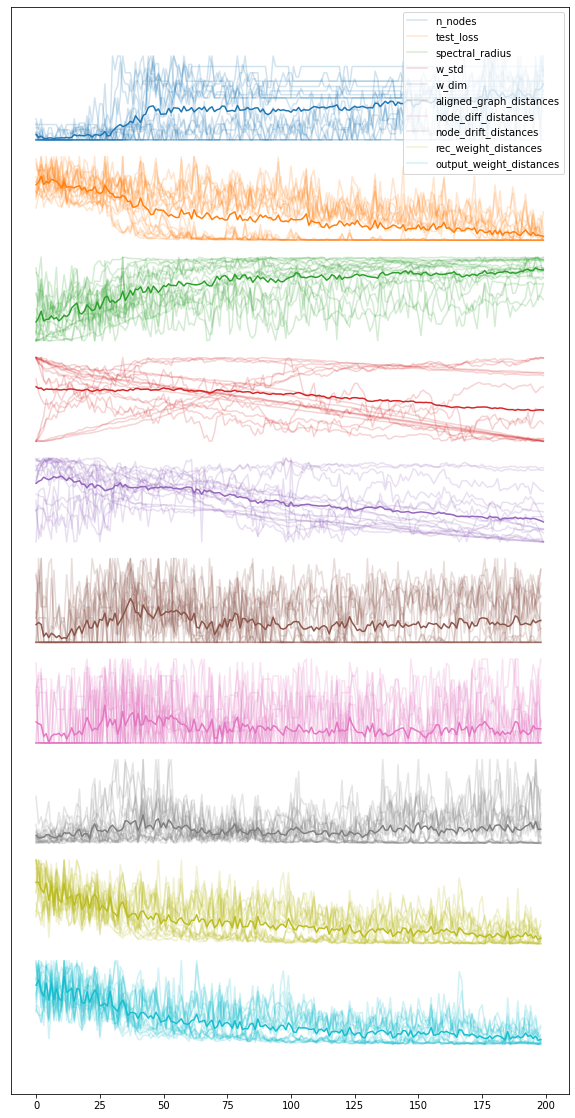

In [24]:
signal_keys = [k for k in signal_dicts.keys()]
signal_dicts_list = [signal_dicts[k] for k in signal_keys]
fig = plot_multiple_signals(signal_dicts_list, key_restriction=None, alpha=0.2)

In [25]:
signal_keys_ordered = signal_keys
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    stage_assignments, t_stage_transitions = assign_time_points_to_stages(signals,
                                                                          performance_criterion=0.05,
                                                                          topological_criterion=0.1,
                                                                          loss_window=20,
                                                                          topological_window=1)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

In [26]:
dict_of_t_stage_transitions

{'analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=0,3_lr=0,001': [117,
  None,
  None],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=0,3_lr=0,01': [29, 44, 98],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=1,2_lr=0,001': [4,
  None,
  None],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=1,2_lr=0,01': [20, 43, 99],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=1_lr=0,001': [7,
  None,
  None],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=0_g=1_lr=0,01': [17, 61, 103],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=0,3_lr=0,001': [169,
  None,
  None],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=0,3_lr=0,01': [33, 43, 98],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=1,2_lr=0,001': [4,
  None,
  None],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=1,2_lr=0,01': [42, 63, 107],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=1_lr=0,001': [22,
  None,
  None],
 'analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=1_lr=0,01': [37, 63, 106],
 'an

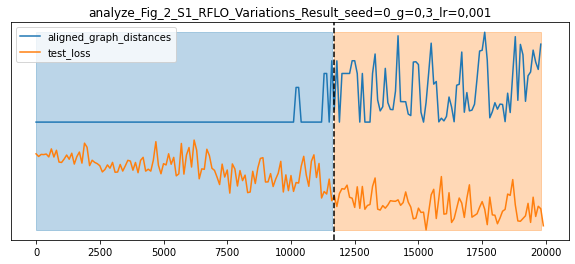

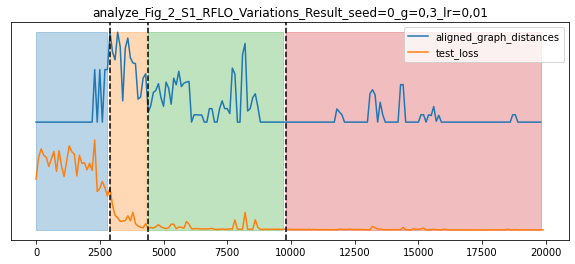

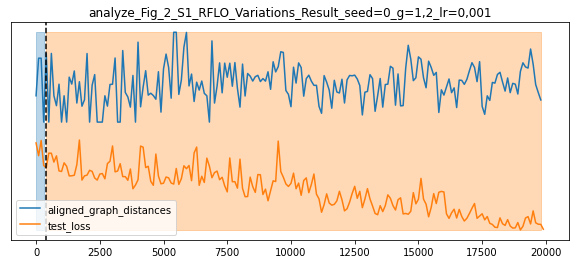

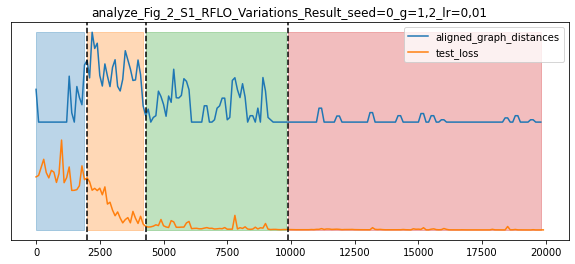

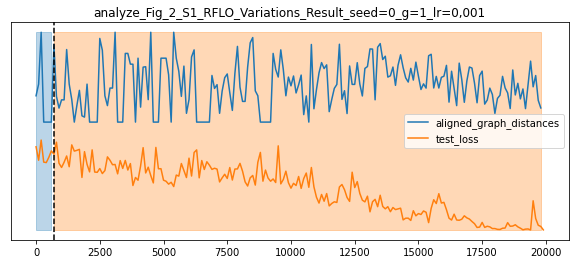

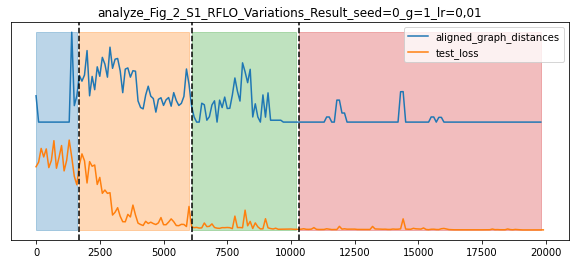

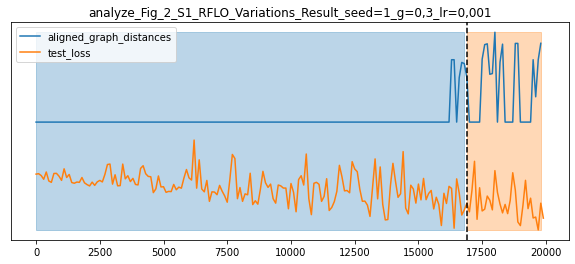

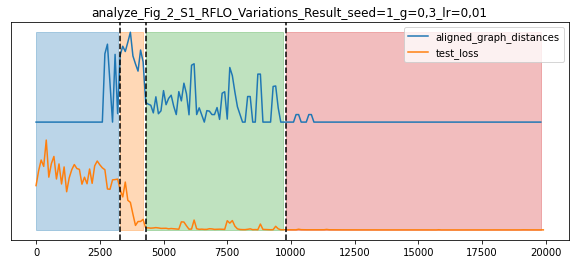

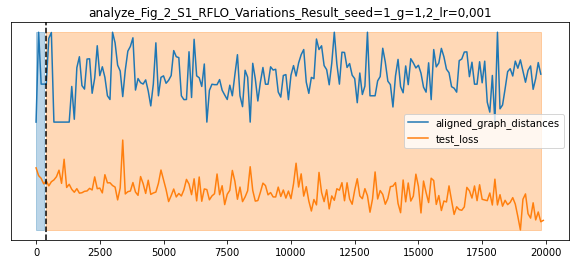

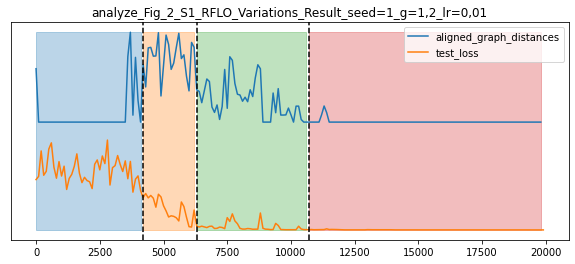

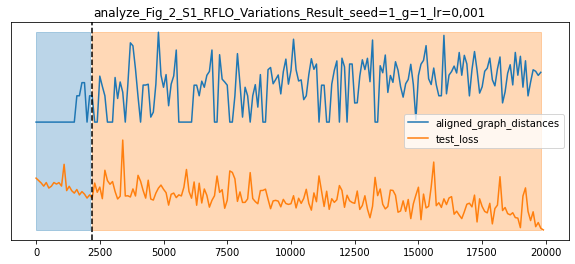

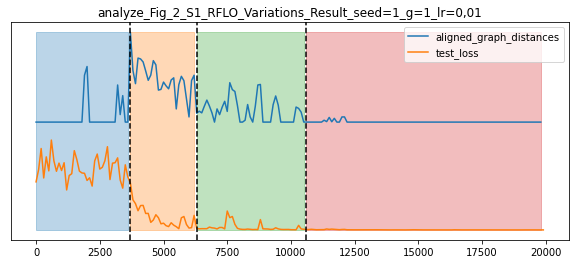

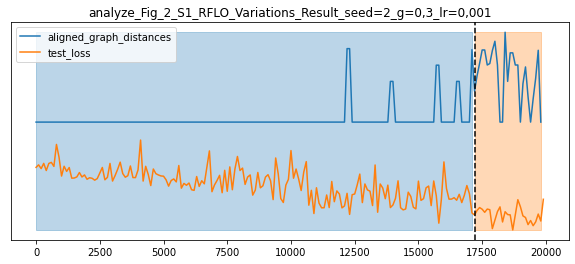

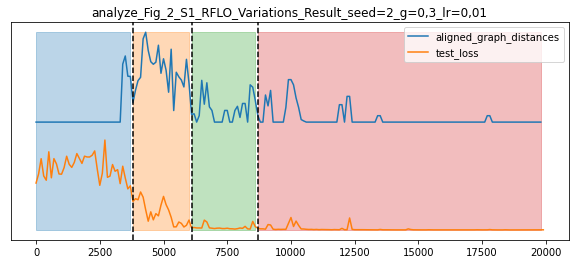

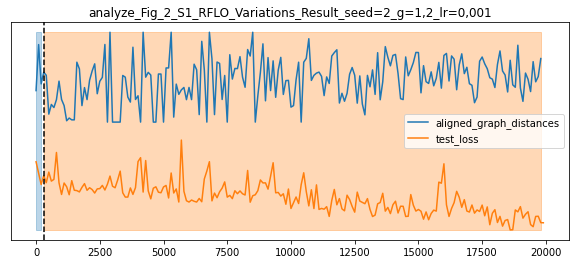

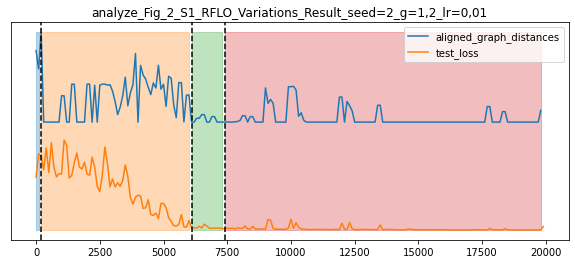

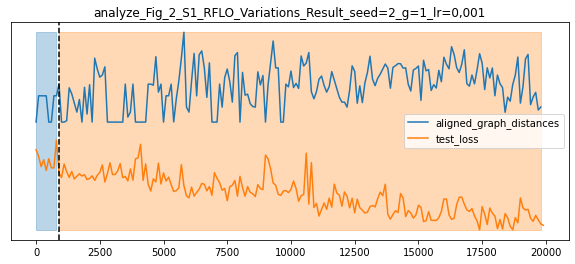

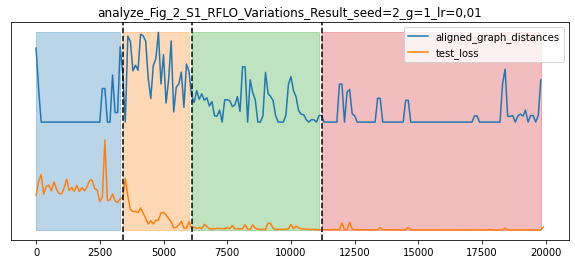

In [29]:
i_analysis = 2
for i_analysis in range(len(signal_keys_ordered)):
    key = signal_keys_ordered[i_analysis]
    indices = checkpoints_dicts[key]['indices']
    fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=True,
                       key_restriction=['aligned_graph_distances', 'test_loss'],
                       stage_assignments=dict_of_stage_assignments[key])
    for t in dict_of_t_stage_transitions[key]:
        if t is not None:
            plt.axvline(indices[t], color='k', linestyle='--')
    plt.title(key)

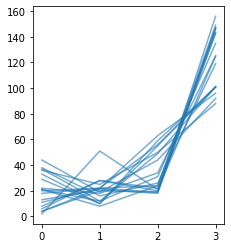

In [15]:
#colors = ['C0', 'C1', 'C2'] * 6
colors= ((['C5'] * 3) + (['C6'] * 3)) * 3
plot_time_spent_in_stages(dict_of_stage_assignments, colors=None)

In [25]:
lr01 = [sa for i_sa, sa in enumerate(list_of_stage_assignments) if 'lr=0,01' in signal_keys[i_sa]]
lr001 = [sa for i_sa, sa in enumerate(list_of_stage_assignments) if 'lr=0,001' in signal_keys[i_sa]]
plot_bar_time_spent_in_stages(lr01)
plot_bar_time_spent_in_stages(lr001)

NameError: name 'list_of_stage_assignments' is not defined

In [11]:
from scipy.ndimage.filters import uniform_filter1d

(0.4099999999999999, 4.590000000000001, 0.0, 0.48346287005568506)

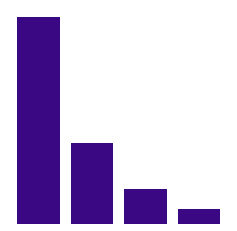

In [55]:
bar_plots = np.zeros((len(signal_keys_ordered), 4))
top_R_values = []
for i_key, key in enumerate(signal_keys_ordered):
    sa = dict_of_stage_assignments[key]
    signals = signal_dicts[key]
    k_filt = 1
    #loss = np.convolve(signals['test_loss'], np.ones(k_filt) / k_filt, 'valid')
    loss = uniform_filter1d(signals['rec_weight_distances'], k_filt, mode='nearest')
    d_loss = loss
    #d_loss = loss[1:] - loss[:-1]
    #d_top = np.convolve(signals['aligned_graph_distances'], np.ones(k_filt) / k_filt, 'valid')
    d_top = uniform_filter1d(signals['aligned_graph_distances'], k_filt, mode='nearest')
    #i_stage = 2
    #idx = np.where(stage_assignments > 0)[0]
    #plt.plot(d_top[idx], d_loss[idx], '.')
    from sklearn.linear_model import LinearRegression
    m = LinearRegression()
    #m.fit(d_top.reshape(-1, 1), d_loss.reshape(-1, 1))
    #print(m.score(d_top.reshape(-1, 1), d_loss.reshape(-1, 1)))
    #top_R_values.append(np.sqrt(m.score(d_top.reshape(-1, 1), d_loss.reshape(-1, 1))) * np.sign(m.coef_[0,0]))
    bar_plots[i_key, :] = np.array([d_loss[np.where(sa == i_stage)[0]].mean() for i_stage in range(1, 5)])
    #plt.plot([1,2,3,4], [d_loss[np.where(sa == i_stage)[0]].mean() for i_stage in range(1, 5)])
fig = plt.figure(figsize=(4,4))    
plt.bar([1,2,3,4], bar_plots.mean(0), color='#3A0882')
plt.axis('off')
#fig.savefig('../../figs/frf_talk/avg_dw_bar.pdf', dpi=300, format='pdf')

In [11]:
bar_plots.shape

(18, 4)

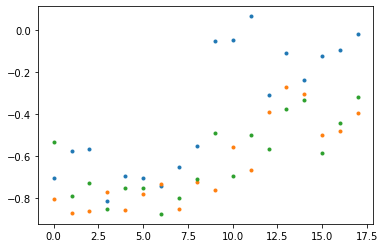

In [40]:
plt.plot(PC_R_values, '.')
plt.plot(CKA_R_values, '.')
plt.plot(top_R_values, '.')

([], [])

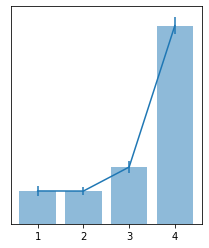

In [16]:
fig = plot_bar_time_spent_in_stages(dict_of_stage_assignments, return_fig=True)
plt.yticks([])

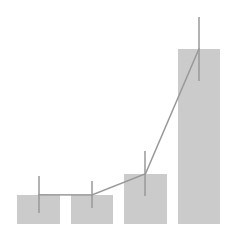

In [37]:
fig = plt.figure(figsize=(4, 4))
color=('0.6')
bins = np.array([0.5, 1.5, 2.5, 3.5, 4.5])
stage_assignments_hists = [np.histogram(sa, bins=bins)[0]
                           for sa in dict_of_stage_assignments.values()]
stage_assignments_hists = np.array(stage_assignments_hists)

mu = stage_assignments_hists.mean(0)
error = stage_assignments_hists.std(0)

plt.bar(bins[:-1] + 0.5, mu, color=color,
        align='center', alpha=0.5)
plt.errorbar(bins[:-1] + 0.5, mu, yerr=error, color=color)
plt.axis('off')
figs_path = '../../figs/frf_talk/'
fig_name = 'stage_occ_rflo_vars'
#fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [10]:
signal_keys

['analyze_rflo_variations_seed=0_lr=0,001_g=0,3',
 'analyze_rflo_variations_seed=0_lr=0,001_g=1',
 'analyze_rflo_variations_seed=0_lr=0,001_g=1,2',
 'analyze_rflo_variations_seed=0_lr=0,01_g=0,3',
 'analyze_rflo_variations_seed=0_lr=0,01_g=1',
 'analyze_rflo_variations_seed=0_lr=0,01_g=1,2',
 'analyze_rflo_variations_seed=1_lr=0,001_g=0,3',
 'analyze_rflo_variations_seed=1_lr=0,001_g=1',
 'analyze_rflo_variations_seed=1_lr=0,001_g=1,2',
 'analyze_rflo_variations_seed=1_lr=0,01_g=0,3',
 'analyze_rflo_variations_seed=1_lr=0,01_g=1',
 'analyze_rflo_variations_seed=1_lr=0,01_g=1,2',
 'analyze_rflo_variations_seed=2_lr=0,001_g=0,3',
 'analyze_rflo_variations_seed=2_lr=0,001_g=1',
 'analyze_rflo_variations_seed=2_lr=0,001_g=1,2',
 'analyze_rflo_variations_seed=2_lr=0,01_g=0,3',
 'analyze_rflo_variations_seed=2_lr=0,01_g=1',
 'analyze_rflo_variations_seed=2_lr=0,01_g=1,2']

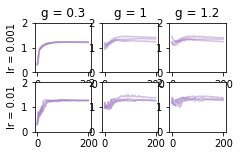

In [13]:
sig = 'spectral_radius'
colors_dict = {'aligned_graph_distances': '#3FA9F5',
               'n_nodes': '#3A0882',
               'test_loss': '#7F7F7F',
               'w_std': 'C8',
               'spectral_radius': 'C4'}
y_lim_dict = {'aligned_graph_distances': 1,
              'n_nodes': 40,
              'test_loss': 1.2,
              'w_std': 0.25,
              'spectral_radius': 2}
for sig in ['spectral_radius']:
    fig = plot_array_of_signals(signal_dicts, root_name=root_name, signal_keys=[sig] ,alpha=0.4,
                                colors=[colors_dict[sig]],
                                return_fig=True, fig_length=2, swap_order=False, common_ylim=[0, y_lim_dict[sig]])
    #for i in range(6):
        #fig.axes[i].axis('off')
        #fig.axes[i].set_title('')
    figs_path = '../../figs/thesis/rflo_examples'
    fig_name = 'rflo_hamburger_vars_{}'.format(sig)
    #fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [11]:
signal_dicts['analyze_rflo_variations_seed=0_lr=0,01_g=1']['w_std']

array([0.17679287, 0.17653337, 0.17622697, 0.17513007, 0.17570579,
       0.17501246, 0.17507924, 0.1751272 , 0.17443401, 0.17471781,
       0.17441569, 0.17405542, 0.17305917, 0.17327982, 0.17235204,
       0.17243801, 0.17199961, 0.17180946, 0.17247397, 0.17236571,
       0.17246751, 0.17232695, 0.1719533 , 0.17225802, 0.17216408,
       0.17177205, 0.17196992, 0.17242661, 0.17196073, 0.1721871 ,
       0.17234424, 0.17251942, 0.17237301, 0.17205112, 0.17199792,
       0.17194536, 0.17185476, 0.17179989, 0.17154822, 0.17148285,
       0.17150011, 0.1711903 , 0.17092809, 0.17089384, 0.17089462,
       0.17082566, 0.17077565, 0.17057259, 0.17050015, 0.1700527 ,
       0.1701299 , 0.17021345, 0.16997277, 0.16943388, 0.16948395,
       0.16945725, 0.16948531, 0.16946668, 0.16936407, 0.16944089,
       0.16887842, 0.16886801, 0.16877525, 0.16879328, 0.16896707,
       0.16877333, 0.16858605, 0.16841252, 0.16828453, 0.16820668,
       0.16838006, 0.16834294, 0.16807207, 0.16802965, 0.16801

In [12]:
np.sqrt(1/32)

0.1767766952966369

In [66]:
!mkdir ../../figs/thesis/rflo_examples

In [49]:
checkpoints_dicts['analyze_rflo_variations_seed=1_lr=0,01_g=1,2']['checkpoints']['checkpoint_0']['rnn'].W_rec.std()

0.20629991190060692

In [50]:
stds = []
for idx in checkpoints_dicts['analyze_rflo_variations_seed=1_lr=0,01_g=1,2']['indices']:
    W = checkpoints_dicts['analyze_rflo_variations_seed=1_lr=0,01_g=1,2']['checkpoints']['checkpoint_{}'.format(idx)]['rnn'].W_rec
    stds.append(W.std())

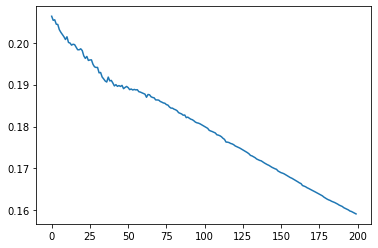

In [51]:
plt.plot(stds)

In [22]:
figs_path = '../figs/'
fig_name = 'g_lr_all_stage_assignments'
fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

In [37]:
signal_keys_ordered

['analyze_rflo_variations_seed=0_lr=0,001_g=0,3',
 'analyze_rflo_variations_seed=1_lr=0,001_g=0,3',
 'analyze_rflo_variations_seed=2_lr=0,001_g=0,3',
 'analyze_rflo_variations_seed=0_lr=0,001_g=1,2',
 'analyze_rflo_variations_seed=1_lr=0,001_g=1,2',
 'analyze_rflo_variations_seed=2_lr=0,001_g=1,2',
 'analyze_rflo_variations_seed=0_lr=0,001_g=1',
 'analyze_rflo_variations_seed=1_lr=0,001_g=1',
 'analyze_rflo_variations_seed=2_lr=0,001_g=1',
 'analyze_rflo_variations_seed=0_lr=0,01_g=0,3',
 'analyze_rflo_variations_seed=1_lr=0,01_g=0,3',
 'analyze_rflo_variations_seed=2_lr=0,01_g=0,3',
 'analyze_rflo_variations_seed=0_lr=0,01_g=1,2',
 'analyze_rflo_variations_seed=1_lr=0,01_g=1,2',
 'analyze_rflo_variations_seed=2_lr=0,01_g=1,2',
 'analyze_rflo_variations_seed=0_lr=0,01_g=1',
 'analyze_rflo_variations_seed=1_lr=0,01_g=1',
 'analyze_rflo_variations_seed=2_lr=0,01_g=1']

In [18]:
for i_analysis in range(18):
    fig = plt.figure(figsize=(6, 6))
    plot_range = 1.7
    plt.xlim([-plot_range, plot_range])
    plt.ylim([-plot_range, plot_range])
    theta = np.arange(0, 2 * np.pi, 0.01)
    plt.plot(np.cos(theta), np.sin(theta), color='k', linestyle='--')
    n_eig = 32
    #i_analysis = 6
    job_name = signal_keys_ordered[i_analysis]
    indices = checkpoints_dicts[job_name]['indices']
    checkpoints = checkpoints_dicts[job_name]['checkpoints']
    n_checkpoints = len(indices)

    topological_distance = signal_dicts[job_name]['aligned_graph_distances']
    i_phase = np.amin(np.where(np.logical_and(topological_distance > 0,
                                              np.roll(topological_distance, -1) > 0,
                                              np.roll(topological_distance, -2) > 0))[0])

    for i_index, i_checkpoint in enumerate(indices):
        W = checkpoints['checkpoint_{}'.format(i_checkpoint)]['rnn'].W_rec
        eigs, vecs = np.linalg.eig(W)
        eigs = eigs[np.argsort(np.abs(eigs))[::-1]]
        #col = color_fader('lightgray', 'C3', i_index / n_checkpoints)
        col = color_fader('C0', 'C3', i_index / n_checkpoints)
        plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], '.', color=col, alpha=0.4)
        plt.plot([1.1+i_index / n_checkpoints * 0.5], [1.1], '.', color=col)

        if i_index == 0:

            plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], 'x', color='k')

        if i_index == i_phase:
            pass
            #plt.plot(np.real(eigs)[:n_eig], np.imag(eigs)[:n_eig], 'x', markersize=10, color='C2')

    #plt.plot(np.real(eigs)[:3], np.imag(eigs)[:3], 'x', markersize=12, color='C3')
    figs_path = '../../figs/thesis/rflo_examples'
    fig_name = 'spectrum_{}'.format(job_name)
    plt.axis('off')
    plt.title(job_name)
    fig.savefig(os.path.join(figs_path, fig_name + '.png'), dpi=300, format='png')
    plt.close()

In [17]:
len(indices)

200